<div style="text-align: center; font-size: 30pt; font-weight: bold; margin: 1em 0em 1em 0em">Homework 3</div>

$\textbf{Auteur}$ : Adel Nabli


$\textbf{ID}$: 20121744

In [1]:
import numpy as np
import math
import matplotlib.pyplot as plt
from scipy import linalg

In [2]:
X_train = np.loadtxt('EMGaussian.train')
X_test = np.loadtxt('EMGaussian.test')

## K-means

The metric to minimize here is the distortion $J(\mu, z) = \sum_{i=1}^N \sum_{k=1}^K z_i^k || x_i - \mu_k ||^2$

____________________________________________________________________

$\textbf{ALGORITHM:}$

* $\textbf{Parameters}$: number of cluters K and tolerance $\epsilon$
* $\textbf{Initialization}$: create random centroïdes
* $\textbf{While}\; \; |J(\mu_{t+1}, z_{t+1}) - J(\mu_t, z_t)| > \epsilon, \; \textbf{do}$:

$\hspace{2cm}$ - $\textbf{for} \; i =1,...,n$, find the closest centroïde $\mu_t^k$ to $x_i$ and assign $x_i$ to the cluster $k$ ($z_i^k=1$)

$\hspace{2cm}$ - $\textbf{Compute}$ the new centroïdes $\mu_{t+1}^k = \dfrac{\sum_i z_i^k x_i}{\sum_i z_i^k}$

_____________________________________________________________________

* We will initialize $\mu$ uniformely on the window given by the data
* $\mu_t = \begin{pmatrix} \mu_t^1 \\ \vdots \\ \mu_t^K \end{pmatrix}$, each row being a 2 dimensional vector
* $Z \in \mathbb{R}^{N \times K}$ is the matrix which contains the clusters of each data point: each row is attributed to a data point and contains its cluster (via a one-hot encoding)

In [3]:
def compute_J(X, mu, Z):
    
    """Compute and returns the distortion for a given set of centroides and X, and z"""
    
    j = 0
    
    for i in range(len(X)):
        
        j += np.linalg.norm(X[i] - Z[i].dot(mu))**2
    
    return(j)

In [4]:
def compute_Z(X, mu):
    
    """Compute and returns the matrix Z for a given dataset and set of centroïdes"""
    
    Z = np.zeros((len(X), len(mu)))
    
    for i in range(len(X)):
        
        distance_min = math.inf
        cluster = None
        
        for k in range(len(mu)):
            
            distance = np.linalg.norm(X[i]-mu[k])
            
            if distance < distance_min:
                
                distance_min = distance
                cluster = k
        
        Z[i][cluster] = 1
    
    return(Z)      

In [5]:
def compute_mu(X, Z):
    
    """Compute and returns the vector mu for a given dataset and Z"""
    
    sum_z = np.sum(Z, axis=0)
    
    return((X.T.dot(Z)/sum_z).T)

In [6]:
def K_means(X, K, epsilon):
    
    # Compute some values usefull to know how to initialize the centroides
    
    max_x, max_y = np.max(X[:, 0]), np.max(X[:, 1])
    min_x, min_y = np.min(X[:, 0]), np.min(X[:, 1])
    scale_x, scale_y = max_x - min_x, max_y - min_y
    
    # Initialize the vector mu and build it
    
    mu0_x = scale_x*np.random.random(K) + min_x
    mu0_y = scale_y*np.random.random(K) + min_y
    
    mu_t = []
    
    for k in range(K):
        
        mu_k = [mu0_x[k], mu0_y[k]]
        mu_t.append(mu_k)
    
    # We apply the algorithm

    difference = math.inf
    Z_t = compute_Z(X, mu_t)
    J_t = compute_J(X, mu_t, Z_t)
    
    while difference > epsilon:
        
        Z_t = compute_Z(X, mu_t)
        mu_t = compute_mu(X, Z_t)
        J_t1 = compute_J(X, mu_t, Z_t)
        difference = np.abs(J_t1 - J_t)
        J_t = J_t1
    
    return(mu_t, Z_t, J_t)

In [7]:
def plot(X, mu, Z, J):
    
    """plot the data to visualize the results of the k-means algorithm"""
    
    colors = ['b', 'g', 'c', 'm']
    colums = np.array([0, 1, 2, 3])
    
    for i in range(len(X)):
        
        plt.scatter(X_train[i, 0], X_train[i, 1], marker='x', color = colors[int(colums.dot(Z[i]))])
    
    plt.scatter(mu[:, 0], mu[:, 1], marker ='o', color='k')
    plt.title('Results of the k-means algorithm, $J=$'+ str(np.round(J, 2)))
    plt.show()

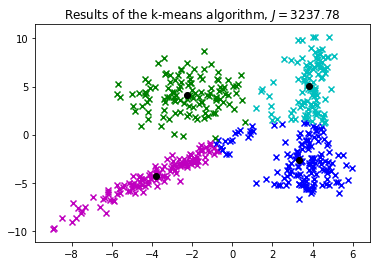

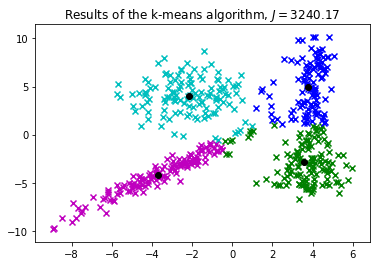

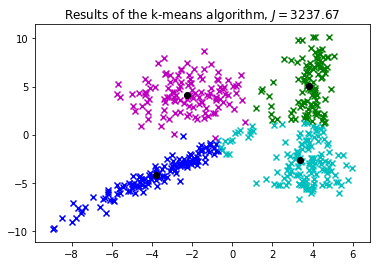

In [8]:
mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

mu, Z, J = K_means(X_train, 4, 0.01)
plot(X_train, mu, Z, J)

## E-M Algorithm

Let $z$ be the hidden variables and $x$ be the observed data. We make the assumption that the $x_i$, $i \in \{1, ..., N\}$ are i.i.d. We suppose that the $z_i \sim \mathcal{M}(\pi_1,...\pi_K)$ and $(x_i \; | \; z_i=k) \sim \mathcal{N} (\mu_k, \Sigma_k)$.
We define $\theta = (\pi, \mu, \Sigma)$.

We want to maximize the log-likelihood  $\log p_{\theta}(x) = \sum_{i=1}^N \log \sum_{z_i} p_{\theta}(x_i, z_i) = \sum_{i=1}^N \log \sum_{k=1}^K \pi_k \mathcal{N}(x_i \; | \; \mu_k, \Sigma_k)$.

For that, we use the $\textit{E-M algorithm}$:

____________________________________________________

$\textbf{ALGORITHM}:$

* $\textbf{Parameters}$: tolerance $\epsilon$
* $\textbf{Initialize}$ the parameters in $\theta$ using the results given by the $\textit{k-means algorithm}$ ($\mu^0 = \mu_{k-means}$ and $\tau^0 = Z_{k-means}$)
* $\textbf{While} \; \;| \log p_{\theta^{t+1}}(x) - \log p_{\theta^{t}}(x) | \; > \; \epsilon$, $\textbf{do}$:

$\hspace{2cm}$ - $\textbf{Compute}$ $\forall i \in \{1,...N\}, \; \forall k \in \{1,...K\}$ the $p_{\theta^t}(z_i = k \;|\; x_i) = \dfrac{\pi_k \mathcal{N}(x_i \; | \; \mu_k^t, \Sigma_k^t)}{\sum_k \pi_k \mathcal{N}(x_i \; | \; \mu_k^t, \Sigma_k^t)} = \tau_i^k(\theta^t)$

$\hspace{2cm}$ - $\textbf{Compute}$ $ \forall k \in \{1,...K\}$ the new values:

$\hspace{2cm}$ $\pi_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k}{N} \quad , \quad \mu_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k x_i}{\sum_{i=1}^N \tau_i^k} \quad , \quad \Sigma_k^{t+1} = \dfrac{\sum_{i=1}^N \tau_i^k (x_i - \mu_k^{t+1})(x_i - \mu_k^{t+1})^T}{\sum_{i=1}^N \tau_i^k}$

_____________________________________________________

* If we are considering the case $\Sigma_k = \sigma_k^2 \mathbb{I}_d$, we have $\sigma_k^{2 \; t+1} = \dfrac{\sum_{i=1}^N \tau_i^k (x_i - \mu_k^{t+1})^T(x_i - \mu_k^{t+1})}{d\sum_{i=1}^N \tau_i^k}$

* We recall that $\mathcal{N}(x_i \; | \; \mu, \Sigma) = \dfrac{1}{(2\pi)^{d/2} |\Sigma|^{1/2}} \exp\Big( - \dfrac{(x_i-\mu)^T \Sigma^{-1}(x_i-\mu)}{2} \Big)$.

* We will work with matrices to store the values of the parameters for every $k$. Thus, $\tau \in \mathbb{R}^{N \times K}$, $\pi \in \mathbb{R}^K$, $\mu \in \mathbb{R}^{K \times d}$, $\Sigma \in \mathbb{R}^{K \times d \times d}$ (and $d=2$ here).

In [9]:
def compute_log_likelihood(X, pi, mu, Sigma):
    
    """Compute and returns the log likelihood"""
    
    L = 0
    
    for i in range(len(X)):
        
        Sum = 0
        
        for k in range(len(pi)):
            
            Sum += (pi[k]/(2*np.pi*np.sqrt(linalg.det(Sigma[k])))) * np.exp(-0.5*(X[i] - mu[k]).T.dot(linalg.inv(Sigma[k])).dot(X[i]-mu[k]))
        
        L += np.log(Sum)
            
    return(L)

In [10]:
def compute_tau(X, pi, mu, Sigma):
    
    """Compute and returns the matrix tau"""
    
    tau = np.zeros((len(X), len(pi)))
    
    for i in range(len(X)):
        
        Sum = 0
        
        for k in range(len(pi)):
            
            tau[i, k ] = (pi[k]/(2*np.pi*np.sqrt(linalg.det(Sigma[k])))) * np.exp(-0.5*(X[i] - mu[k]).T.dot(linalg.inv(Sigma[k])).dot(X[i]-mu[k]))
            Sum += tau[i, k]
        
        tau[i, :] *= 1/Sum
    
    return(tau)

In [11]:
def compute_pi(tau):
    
    """Compute and returns the vector pi"""
    
    return(np.sum(tau, axis=0) / len(tau))

In [12]:
def compute_mu(X, tau):
    
    """Compute and returns the matrix mu"""
    
    return((X.T.dot(tau) / np.sum(tau, axis=0)).T)

In [13]:
def compute_sigma(X, tau, mu, is_diag=False):
    
    """Compute and returns the matrix Sigma"""
    
    d = np.shape(mu)[1]
    K = len(mu)
    Sigma = []
    
    for k in range(K):
        
        sigma = np.zeros((d, d))
        
        for i in range(len(X)):
            
            if is_diag:
                
                sigma += np.diag([tau[i, k]*(X[i] - mu[k]).T.dot(X[i] - mu[k])*(1/d)]*d)
            
            else:
                
                sigma += tau[i, k]*np.tensordot((X[i] - mu[k]),(X[i] - mu[k]).T, axes=0)
        
        sigma *= 1/np.sum(tau[:,k])
        Sigma.append(sigma)
            
    return(Sigma)

In [14]:
def E_M(X, K, epsilon, Sigma_is_diag=False):
    
    """Apply the E-M algorithm described before and returns the parameters computed"""
    
    # Initialization
    
    mu, tau, J = K_means(X, K, epsilon)
    
    mu_t = mu
    tau_t = tau
    pi_t = compute_pi(tau_t)
    Sigma_t = compute_sigma(X, tau_t, mu_t, is_diag=Sigma_is_diag)
    log_like_t = compute_log_likelihood(X, pi_t, mu_t, Sigma_t)
    
    difference = math.inf
    
    # The algorithm
    
    while difference > epsilon:
        
        tau_t = compute_tau(X, pi_t, mu_t, Sigma_t)
        mu_t = compute_mu(X, tau_t)
        Sigma_t = compute_sigma(X, tau_t, mu_t, is_diag=Sigma_is_diag)
        pi_t = compute_pi(tau_t)
        log_like_t1 = compute_log_likelihood(X, pi_t, mu_t, Sigma_t)
        difference = np.abs(log_like_t1 - log_like_t)
        log_like_t = log_like_t1
    
    return(pi_t, mu_t, Sigma_t, tau_t, log_like_t)

In [15]:
def gaussian(x, mu, Sigma):
    
    """Returns the value of the density of probability for a given vector x"""
    
    return((1/(2*np.pi*np.sqrt(linalg.det(Sigma)))) * np.exp(-0.5*(x-mu).T.dot(linalg.inv(Sigma)).dot(x-mu)))
        

In [16]:
def plot_EM(X, Tau, mu, Sigma, log_like):
    
    """Plot the data to visualize the results of the E-M algorithm"""
    
    colors = ['b', 'g', 'c', 'm']
    colums = np.array([0, 1, 2, 3])
    
    # plot the data and attribute a color to each cluster
    
    fig = plt.figure (figsize=(8,8))
    ax = fig.add_subplot(111)
    
    for i in range(len(X)):
        
        ax.scatter(X_train[i, 0], X_train[i, 1], marker='x', color = colors[np.where(Tau[i,:]==max(Tau[i,:]))[0][0]])
    
    # plot the centroïdes
    
    ax.scatter(mu[:, 0], mu[:, 1], marker ='o', color='k')
    
    # plot the contour
    
    ## We create a 2-dimensional grid

    borne_inf_0 = np.min(X[:, 0])-1
    borne_sup_0 = np.max(X[:, 0])+1
    T0 = np.linspace(borne_inf_0, borne_sup_0, 100)

    borne_inf_1 = np.min(X[:, 1])-1
    borne_sup_1 = np.max(X[:, 1])+1
    T1 = np.linspace(borne_inf_1, borne_sup_1, 100)

    T = np.reshape([[[i,j] for i in T0] for j in T1], (len(T0)*len(T1), 2))

    ## We plot the contours for every cluster
    
    for k in range(len(Sigma)):
        
        ax.contour(T0, T1, np.reshape([gaussian(t, mu[k], Sigma[k]) for t in T], (len(T0), len(T1))), 3)
    
    plt.title('Results of the E-M algorithm, $Log.likelihood(train)=$'+ str(np.round(log_like, 2)))
    plt.ylim(-10, 10)
    plt.xlim(borne_inf_0, borne_sup_0)
    plt.show()

pi= [0.22345995 0.44493166 0.19536332 0.13624507] 
 
 mu= [[-2.25565929  4.31875744]
 [ 2.50183065 -1.486975  ]
 [-4.43239367 -4.87119267]
 [ 3.9548967   6.63738849]] 
 
 Sigma= [array([[2.37000631, 0.        ],
       [0.        , 2.37000631]]), array([[6.39410085, 0.        ],
       [0.        , 6.39410085]]), array([[3.23900535, 0.        ],
       [0.        , 3.23900535]]), array([[1.72308237, 0.        ],
       [0.        , 1.72308237]])] 
 
 Log-likelihood(test)= -2692.190723447696


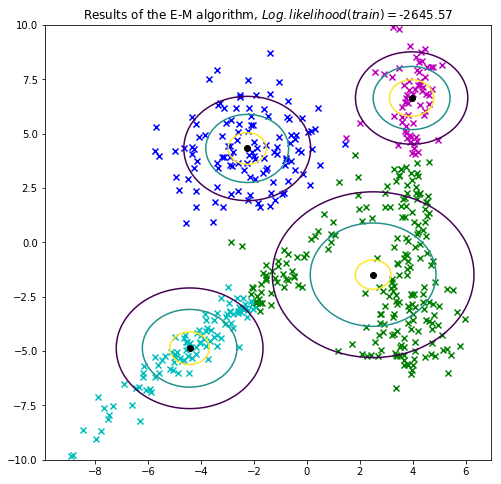

pi= [0.30567918 0.25693035 0.25157315 0.18581732] 
 
 mu= [[-3.05951436 -3.53223482]
 [ 3.98134888  3.84273204]
 [-2.03402669  4.17293188]
 [ 3.79947966 -3.77389639]] 
 
 Sigma= [array([[6.25381427, 6.06178478],
       [6.06178478, 6.19329898]]), array([[ 0.20829936,  0.27507508],
       [ 0.27507508, 11.92706093]]), array([[2.90596446, 0.20799901],
       [0.20799901, 2.75678519]]), array([[0.91138999, 0.05560931],
       [0.05560931, 1.9147375 ]])] 
 
 Log-likelihood(test)= -2409.2111248819547


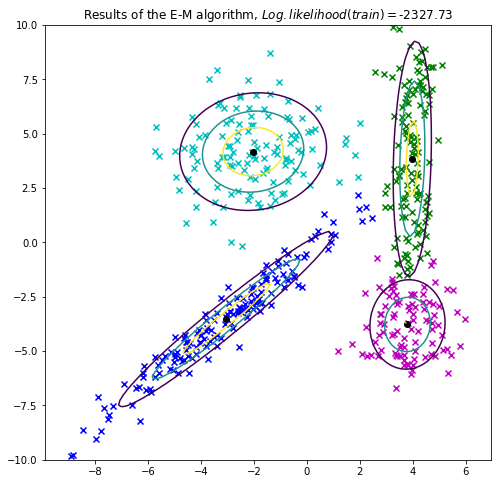

In [17]:
pi, mu, Sigma, Tau, log_like = E_M(X_train, 4, 0.01, Sigma_is_diag=True)
log_like_test = compute_log_likelihood(X_test, pi, mu, Sigma)
print('pi=',pi, '\n \n mu=', mu, '\n \n Sigma=', Sigma, '\n \n Log-likelihood(test)=', log_like_test)
plot_EM(X_train, Tau, mu, Sigma, log_like)

pi, mu, Sigma, Tau, log_like = E_M(X_train, 4, 0.01, Sigma_is_diag=False)
log_like_test = compute_log_likelihood(X_test, pi, mu, Sigma)
print('pi=',pi, '\n \n mu=', mu, '\n \n Sigma=', Sigma, '\n \n Log-likelihood(test)=', log_like_test)
plot_EM(X_train, Tau, mu, Sigma, log_like)